In [ ]:
# periodic time series

#  time series modeling process

# 1. stationary test
#    trend model:
#         Aggregation – taking average for a time period like monthly/weekly averages
#         Smoothing – taking rolling averages
#         Polynomial Fitting – fit a regression model
#    seasonality model:
#         differencing
#         model fitting
# 2. stationalize time series
#       detrend
#       remove seasonality
# 3. model the stationary part of time series        

#    seasonal-ARIMA 

# 4. perform prediction 


# TO DO
# plain time series prediction
# periodic time series prediction

# https://dandelion.eu/datamine/open-big-data/

# http://www.johnwittenauer.net/a-simple-time-series-analysis-of-the-sp-500-index/

# TO DO: 

# Statistics programming 

# book:

# Probabilistic Programming and Bayesian Methods for Hackers 
# http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Prologue/Prologue.ipynb

In [ ]:
# Examples:

# stock prediction
# https://bitbucket.org/joexdobs/ml-classifier-gesture-recognition/wiki/stock-example/
# predict-future-stock-price-using-machine-learning.md

# statsmodels:
#  http://statsmodels.sourceforge.net/stable/index.html

# http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

# http://nbviewer.jupyter.org/gist/ChadFulton/5127108f4c7025ed2648

# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

# http://nbviewer.jupyter.org/github/jakevdp/SeattleBike/blob/master/SeattleCycling.ipynb

# book
# http://shelfjoy.com/shelfjoy/17-essential-machine-learning-books-suggested-by-michael-i-jordan-from-berkeley

In [ ]:
# BASELINE

#  GP
#  S-ARIMA
#  SVR

#  RF
#  GBT
#  xgboosted 

# TO DO:
# keep the same training dataset

In [1]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import IPython
from IPython.display import display

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

import statsmodels as sm

# local packages 
import utils_libs
from utils_data_prep import *
from utils_causal import *

Using TensorFlow backend.
/home/guo/.local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
# DATASETS

# http://redd.csail.mit.edu/readme.txt
# uci: stock, house power load, 

# http://cseweb.ucsd.edu/∼yaq007/NASDAQ100 stock data.html


In [2]:
# ---- data visualization utilities ----

def y_distribution_plot( ylist, title_str ):
    
    fig = plt.figure()
    n, bins, patches = plt.hist(ylist, normed=1, facecolor='green', alpha=0.75)

    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.title(title_str)
    plt.grid(True)
#   fig.savefig('./results/classDis.jpg', format='jpg', bbox_inches='tight')  
    
def multivariate_ts_plot( dta_df, title_str ):
        
    matplotlib.rcParams.update({'font.size': 15})
    figure_size = (15.4,7)
    legend_font = 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )
    
    tmpt = range(dta_df.shape[0])
    for i in dta_df.columns:
        
        tmpx = list(dta_df[i])    
        plt.plot( tmpt, tmpx, label= i )

    plt.title( title_str )
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')

# file_list = ["../../dataset/dataset_ts/air_xtrain.dat", \
#             "../../dataset/dataset_ts/air_xtest.dat",\
#             "../../dataset/dataset_ts/air_ytrain.dat", \
#             "../../dataset/dataset_ts/air_ytest.dat"]


In [3]:
# ---- common parameters ----
para_uni_variate = False
para_train_test_split = False
para_win_size = 200
para_is_stateful = False


In [ ]:
# ---- DATA power plant ----

file_name = ['plant-irradiance.csv', 'plant-temperature.csv', 'weather-cloudcover.csv', \
             'weather-dewpoint.csv', 'weather-humidity.csv', 'weather-pressure.csv', 'weather-temperature.csv',\
             'weather-windbearing.csv', 'weather-windspeed.csv']

# load training data data
addr = "../../dataset/ts/power_plant/training/"

idx = range(19)
cols = ['id', 'day'] + idx


file_path = addr + 'plant-power.csv'
dta_df = pd.read_csv( file_path, sep=',', names = cols, header = 0 )
# print dta_df.iloc[0]

tmp = np.asarray( dta_df[ dta_df['id']==1 ].drop(['id', 'day'], axis = 1) )
stack_ts = np.expand_dims( tmp.flatten(), -1 )

print np.shape(stack_ts)

for i in file_name:
    
    file_path = addr + i
    dta_df = pd.read_csv( file_path ,sep=',', names = cols, header = 0 )
    
    print 'Shape of the dataset: ', dta_df.shape
    
    tmp_ts = np.asarray( dta_df[ dta_df['id']==1 ].drop(['id', 'day'], axis=1) )
    var_ts = np.expand_dims( tmp_ts.flatten(), -1 )
    
    stack_ts = np.concatenate( (stack_ts, var_ts), axis=1 )

vari_name = ['power', 'irradiance', 'p-temperature', 'cloudcover', 'dewpoint', 'humidity', 'pressure', \
             'temperature', 'windbearing', 'windspeed']


dta_df = pd.DataFrame( stack_ts, columns = vari_name )

print dta_df.shape
print dta_df.columns

# ---- ----

# prepare training and testing data
split_idx = int(0.8*dta_df.shape[0])
para_train_range = (0, 5400)
para_test_range  = (5400, 6954)

target_col = 'power'
feature_cols = ['p-temperature', 'cloudcover', 'dewpoint', 'humidity', 'temperature', 'windbearing', 'windspeed']
# 'irradiance'
# 'pressure'

x_train, x_test, y_train, y_test = \
build_training_testing_data_4learning( dta_df, target_col, feature_cols, \
                                      para_uni_variate, para_train_test_split, para_win_size, \
                                      para_train_range, para_test_range, para_is_stateful )

print 'Shape of training and testing dataset: ', np.shape(x_train), np.shape(y_train), \
                                                 np.shape(x_test), np.shape(y_test)

    
# Y transformation if necessary 
# y_train = log(y_train+1e-10)
# y_test = log(y_test+1e-10)
    
# visualization
y_distribution_plot( y_train, 'y in training_data' )
y_distribution_plot( y_test,  'y in testing_data' )


multivariate_ts_plot( dta_df[['power']], 'power' )

multivariate_ts_plot( dta_df[['p-temperature', 'temperature']], 'temp' )

multivariate_ts_plot( dta_df[['windbearing', 'windspeed']], 'wind' )

multivariate_ts_plot( dta_df[['cloudcover', ]], 'cloudcover' )

multivariate_ts_plot( dta_df[['dewpoint' ]], 'dewpoint' )

multivariate_ts_plot( dta_df[[ 'humidity' ]], 'humidity' )

multivariate_ts_plot( dta_df[[ 'irradiance' ]], 'irradiance' )

multivariate_ts_plot( dta_df[[ 'pressure' ]], 'pressure' )

In [ ]:
# statisical test 
for i in vari_name:
    print '--', i, stationary_test( np.asarray(dta_df[i]) )

In [ ]:
x_train.dump("../../dataset/dataset_ts/plant_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/plant_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/plant_xtest.dat")
y_test.dump("../../dataset/dataset_ts/plant_ytest.dat")

# prepare data for baselines
files = ["../../dataset/dataset_ts/plant_xtrain.dat", "../../dataset/dataset_ts/plant_xtest.dat",
         "../../dataset/dataset_ts/plant_ytrain.dat",  "../../dataset/dataset_ts/plant_ytest.dat"]

prepare_train_test_RETAIN(files, "../../dataset/dataset_ts/data_to_share/", "plant")
    
prepare_train_test_DualRNN(dta_df, target_col, feature_cols, para_train_range, para_test_range, \
                           "../../dataset/dataset_ts/data_to_share/", "plant",\
                           para_win_size, para_is_stateful)

In [ ]:
# for statistical models
x_train, x_test = build_training_testing_data_4statistics( dta_df, target_col, feature_cols, \
                                para_uni_variate, \
                                para_train_range, para_test_range)

print np.shape(x_train), np.shape(x_test)
x_train.dump("../../dataset/dataset_ts/plant_xtrain_statis.dat")
x_test.dump("../../dataset/dataset_ts/plant_xtest_statis.dat")

Shape of the dataset:  (43824, 13) Index([u'No', u'year', u'month', u'day', u'hour', u'pm2.5', u'DEWP', u'TEMP',
       u'PRES', u'cbwd', u'Iws', u'Is', u'Ir'],
      dtype='object')
(41757, 13)
Shape of training and testing dataset:  (8000, 200, 7) (8000,) (2000, 200, 7) (2000,)


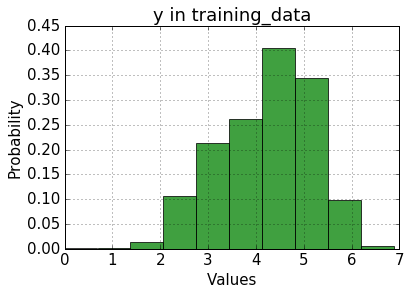

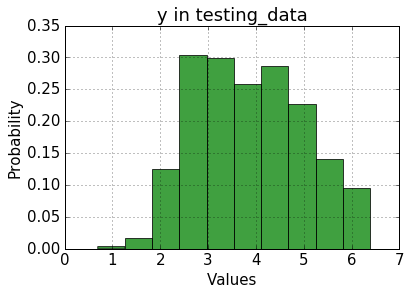

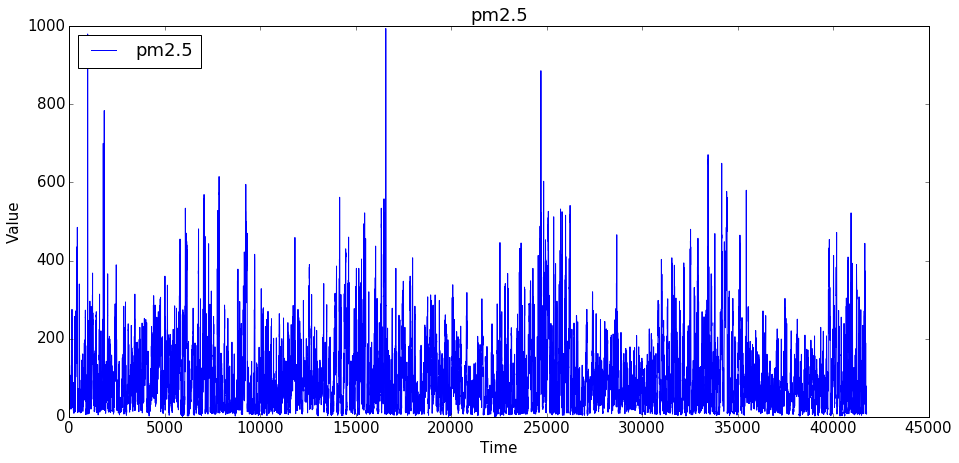

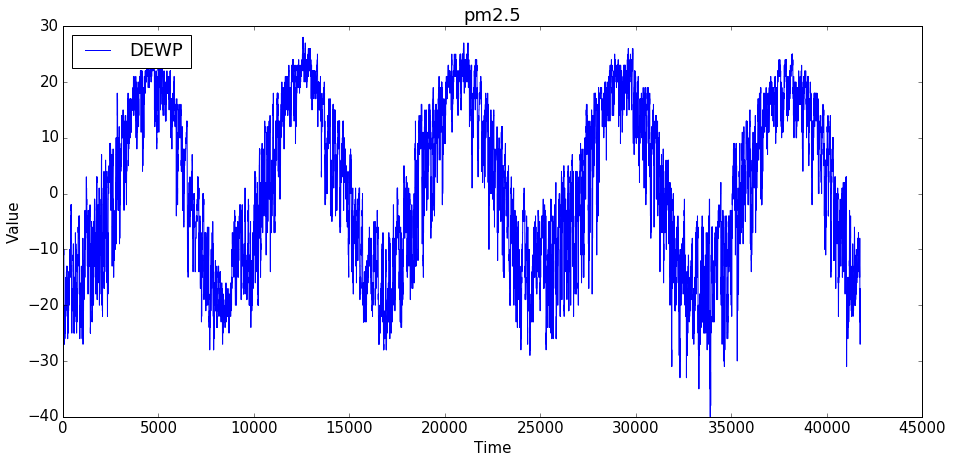

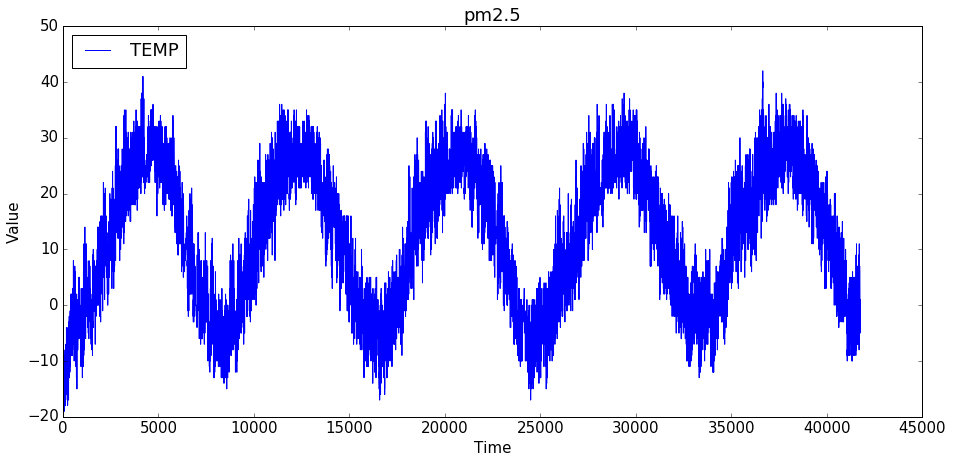

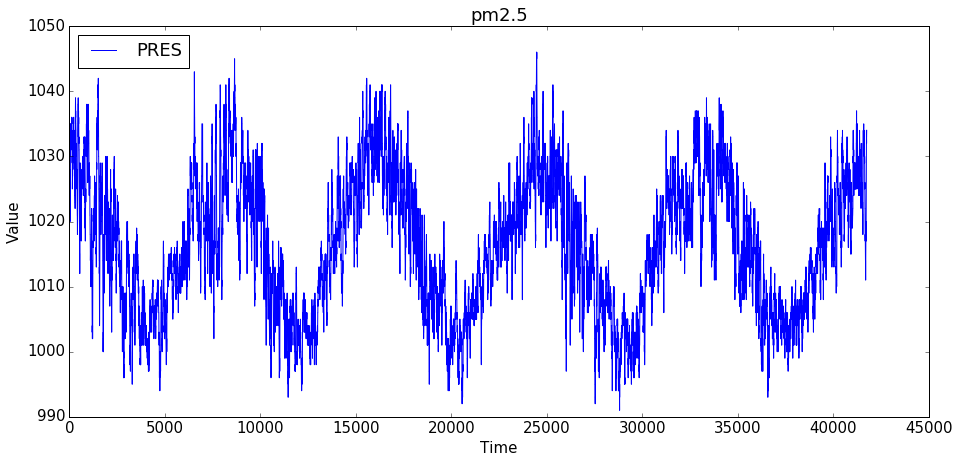

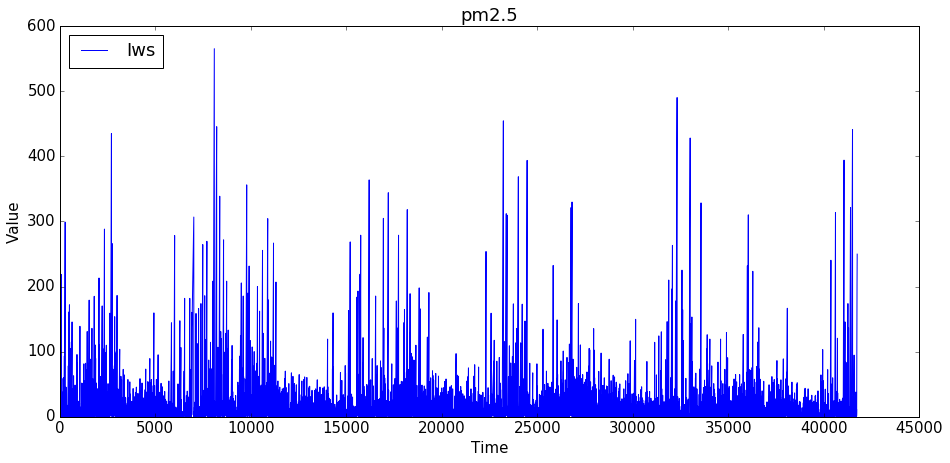

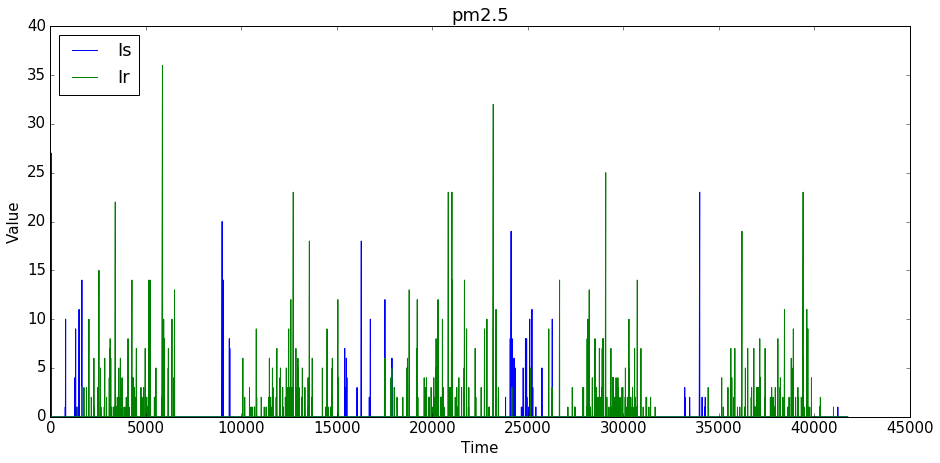

In [4]:
# ---- DATA pm2.5 ----

# load data
addr = "../../dataset/dataset_ts/pm25_bj.csv"
dta_df = pd.read_csv( addr ,sep=',')
print 'Shape of the dataset: ', dta_df.shape, dta_df.columns

# filter out NULL data
dta_df = dta_df.dropna(axis=0, how='any')
print dta_df.shape


# prepare training and testing data
split_idx = int(0.7*dta_df.shape[0])
para_train_range = (0, 8200)
para_test_range  = (8200, 10400)

target_col = 'pm2.5'
feature_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']

x_train, x_test, y_train, y_test = \
build_training_testing_data_4learning( dta_df, target_col, feature_cols, \
                                      para_uni_variate, para_train_test_split, para_win_size, \
                                      para_train_range, para_test_range, para_is_stateful )

print 'Shape of training and testing dataset: ', np.shape(x_train), np.shape(y_train), \
                                                 np.shape(x_test), np.shape(y_test)

# test
y_train = log(y_train + 1e-5)
y_test  = log(y_test + 1e-5)
    
# visualization
y_distribution_plot( y_train, 'y in training_data' )
y_distribution_plot( y_test,  'y in testing_data' )


multivariate_ts_plot( dta_df[['pm2.5']], 'pm2.5' )

multivariate_ts_plot( dta_df[['DEWP']], 'pm2.5' )

multivariate_ts_plot( dta_df[['TEMP']], 'pm2.5' )

multivariate_ts_plot( dta_df[['PRES', ]], 'pm2.5' )


multivariate_ts_plot( dta_df[['Iws' ]], 'pm2.5' )

multivariate_ts_plot( dta_df[[ 'Is', 'Ir' ]], 'pm2.5' )

In [ ]:
# statisical test 
for i in ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']:
    print '--', i, stationary_test( np.asarray(dta_df[i]) )

In [6]:
x_train.dump("../../dataset/dataset_ts/pm25_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/pm25_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/pm25_xtest.dat")
y_test.dump("../../dataset/dataset_ts/pm25_ytest.dat")

# prepare data for baselines
files = ["../../dataset/dataset_ts/pm25_xtrain.dat", "../../dataset/dataset_ts/pm25_xtest.dat",
         "../../dataset/dataset_ts/pm25_ytrain.dat",  "../../dataset/dataset_ts/pm25_ytest.dat"]

prepare_train_test_RETAIN(files, "../../dataset/dataset_ts/data_to_share/", "pm25")
    
prepare_train_test_DualRNN(dta_df, target_col, feature_cols, para_train_range, para_test_range, \
                           "../../dataset/dataset_ts/data_to_share/", "pm25",\
                           para_win_size, para_is_stateful, True)

(8000, 200, 7) (8000, 1) (2000, 200, 7) (2000, 1)
(8000, 201, 6) (8000, 200) (8000,)
(2000, 201, 6) (2000, 200) (2000,)


In [ ]:
# for statistical models
x_train, x_test = build_training_testing_data_4statistics( dta_df, target_col, feature_cols, \
                                para_uni_variate, \
                                para_train_range, para_test_range)

print np.shape(x_train), np.shape(x_test)
x_train.dump("../../dataset/dataset_ts/pm25_xtrain_statis.dat")
x_test.dump("../../dataset/dataset_ts/pm25_xtest_statis.dat")


In [9]:
x_train.dump("../../dataset/dataset_ts/energy_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/energy_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/energy_xtest.dat")
y_test.dump("../../dataset/dataset_ts/energy_ytest.dat")

In [10]:
y_test[:10]

array([ 3.91202321,  3.6888797 ,  3.6888797 ,  3.6888797 ,  4.24849538,
        4.09434473,  3.6888797 ,  3.91202321,  3.6888797 ,  3.91202321])

Shape of the dataset:  (19735, 29) Index([u'date', u'Appliances', u'lights', u'T1', u'RH_1', u'T2', u'RH_2',
       u'T3', u'RH_3', u'T4', u'RH_4', u'T5', u'RH_5', u'T6', u'RH_6', u'T7',
       u'RH_7', u'T8', u'RH_8', u'T9', u'RH_9', u'T_out', u'Press_mm_hg',
       u'RH_out', u'Windspeed', u'Visibility', u'Tdewpoint', u'rv1', u'rv2'],
      dtype='object')
Shape of training and testing dataset:  (8000, 200, 14) (8000,) (2000, 200, 14) (2000,)


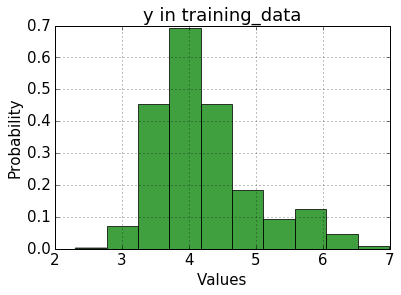

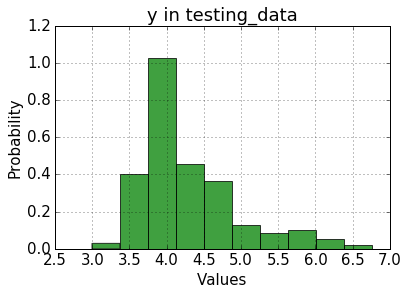

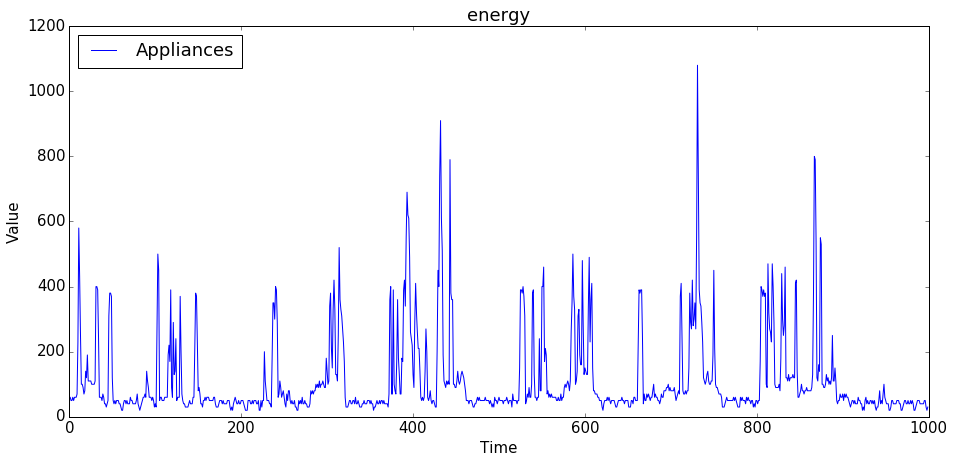

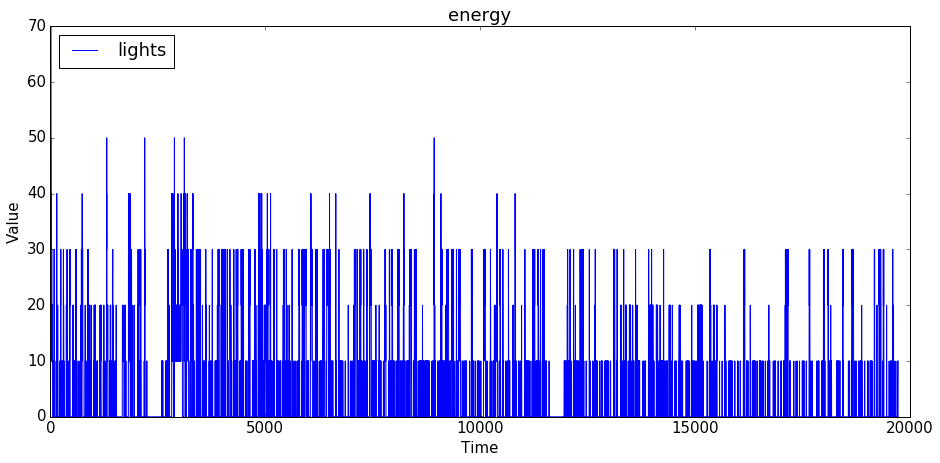

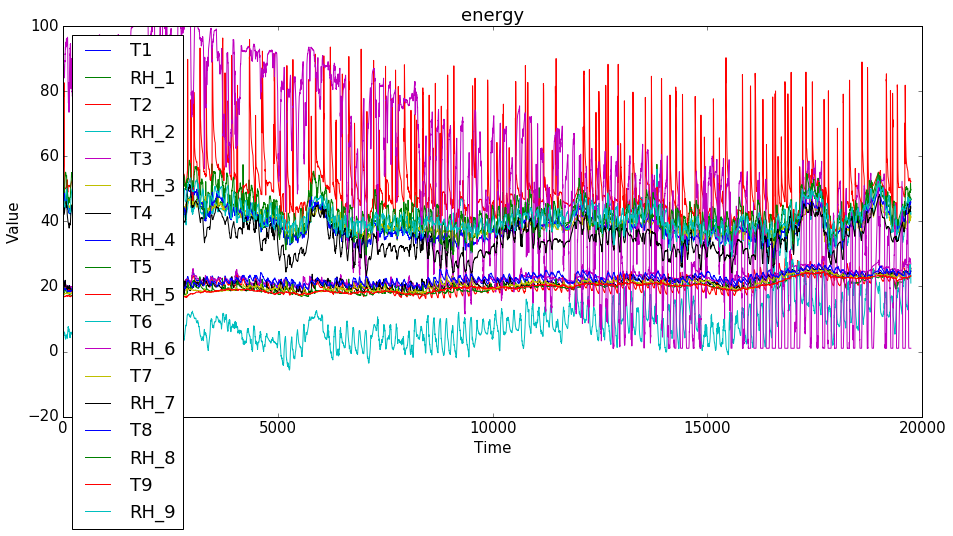

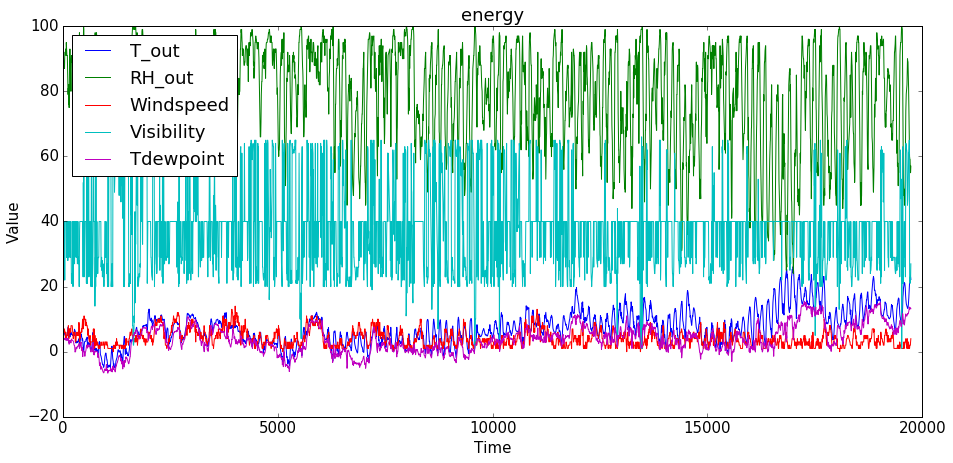

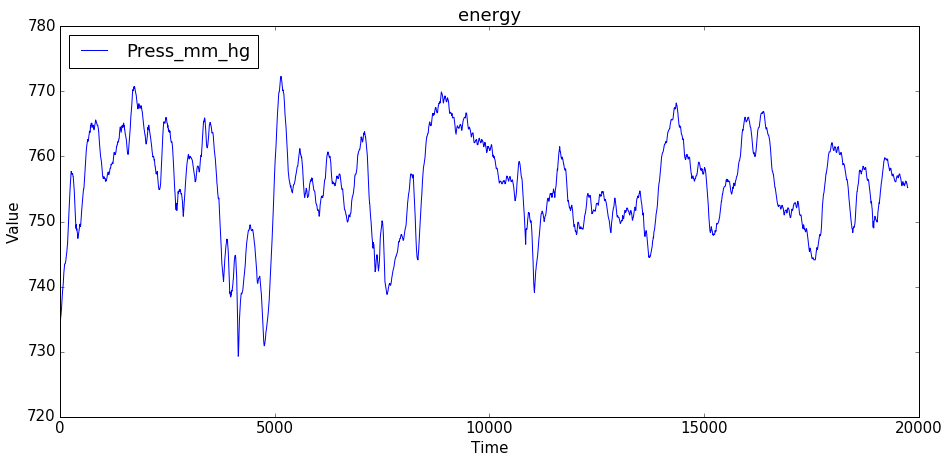

In [7]:
# ---- DATA applicance energy consumption ----

# load data
addr = "../../dataset/dataset_ts/app_energy.csv"
dta_df = pd.read_csv( addr ,sep=',')
print 'Shape of the dataset: ', dta_df.shape, dta_df.columns

# prepare training and testing data
split_idx = int(0.7*dta_df.shape[0])
para_train_range = (0, 8200)
para_test_range  = (8200, 10400)


target_col = 'Appliances'
feature_cols = [ 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9' , 'T_out', 'Windspeed', 'RH_out', 'Tdewpoint' 
#                 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',\
#                 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9'
               ]
#'Visibility',  
# 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',  'Tdewpoint',
               
x_train, x_test, y_train, y_test = \
build_training_testing_data_4learning( dta_df, target_col, feature_cols, \
                                para_uni_variate, para_train_test_split, para_win_size, \
                                para_train_range, para_test_range, para_is_stateful )

print 'Shape of training and testing dataset: ', np.shape(x_train), np.shape(y_train), \
                                                 np.shape(x_test), np.shape(y_test)


y_train = log(y_train+1e-5)
y_test = log(y_test+1e-5)
    
# visualization
y_distribution_plot( y_train, 'y in training_data' )
y_distribution_plot( y_test,  'y in testing_data' )


multivariate_ts_plot( dta_df[['Appliances']].iloc[:1000], 'energy')

multivariate_ts_plot( dta_df[['lights']], 'energy')

multivariate_ts_plot( dta_df[['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',\
                             'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9']], 'energy')

multivariate_ts_plot( dta_df[[ 'T_out', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']], 'energy')

multivariate_ts_plot( dta_df[['Press_mm_hg']], 'energy')

In [ ]:
# statisical test 
tmpcol = [target_col] + feature_cols 
for i in tmpcol:
    print '--', i, stationary_test( np.asarray(dta_df[i]) )

In [8]:
x_train.dump("../../dataset/dataset_ts/energy_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/energy_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/energy_xtest.dat")
y_test.dump("../../dataset/dataset_ts/energy_ytest.dat")


# prepare data for baselines

files = ["../../dataset/dataset_ts/energy_xtrain.dat", "../../dataset/dataset_ts/energy_xtest.dat",
         "../../dataset/dataset_ts/energy_ytrain.dat", "../../dataset/dataset_ts/energy_ytest.dat"]

prepare_train_test_RETAIN(files, "../../dataset/dataset_ts/data_to_share/", "energy")
    
prepare_train_test_DualRNN(dta_df, target_col, feature_cols, para_train_range, para_test_range, \
                           "../../dataset/dataset_ts/data_to_share/", "energy",\
                           para_win_size, para_is_stateful, True)

(8000, 200, 14) (8000, 1) (2000, 200, 14) (2000, 1)
(8000, 201, 13) (8000, 200) (8000,)
(2000, 201, 13) (2000, 200) (2000,)


In [ ]:
# for statistical models
x_train, x_test = build_training_testing_data_4statistics( dta_df, target_col, feature_cols, \
                                para_uni_variate, \
                                para_train_range, para_test_range)

print np.shape(x_train), np.shape(x_test)
x_train.dump("../../dataset/dataset_ts/energy_xtrain_statis.dat")
x_test.dump("../../dataset/dataset_ts/energy_xtest_statis.dat")


In [ ]:
# ---- DATA house-power for machine learning ----

# Date;Time;Global_active_power;Global_reactive_power;
# Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3


dta_df = pd.read_csv( addr ,sep=';')
print 'Shape of the dataset: ', dta_df.shape, dta_df.columns

split_idx = int(0.8*dta_df.shape[0])
para_train_range = (0, split_idx)
para_test_range  = (split_idx, dta_df.shape[0])

# clean 
dta_df.drop( dta_df[ dta_df['Global_active_power'] == '?' ].index, inplace=True )
dta_df = dta_df.dropna(axis=0)

print dta_df.shape

# type conversion
tmpcol = [ 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',\
          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3' ]

for i in tmpcol:
    dta_df[i] = dta_df[i].astype(float)


x_train, x_test, y_train, y_test = \
build_training_testing_data_4learning( dta_df, 'Voltage', ['Global_active_power','Sub_metering_1'], \
                                para_uni_variate, para_train_test_split, para_win_size, \
                                para_train_range, para_test_range, para_is_stateful )

print 'Shape of training and testing dataset: ', np.shape(x_train), np.shape(y_train),\
    np.shape(x_test), np.shape(y_test)


# visualization
y_distribution_plot( y_train, 'y in training_data' )
y_distribution_plot( y_test,  'y in testing_data' )

# tmpdf = dta_df.drop(['Date', 'Time', 'Voltage'], axis=1)
# multivariate_ts_plot( tmpdf, 'house-power' )

multivariate_ts_plot( dta_df[ ['Global_active_power', 'Global_reactive_power',\
                               'Global_intensity'] ],\
                     'house-power' )

multivariate_ts_plot( dta_df[ ['Voltage'] ], 'house-power' )

multivariate_ts_plot( dta_df[ ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'] ], \
                     'house-power' )

In [ ]:
# house power

# fix the training and testing datasets by materialization
x_train.dump("../../dataset/dataset_ts/power_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/power_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/power_xtest.dat")
y_test.dump("../../dataset/dataset_ts/power_ytest.dat")


In [ ]:
# ---- DATA air-quality dataset for machine learning ---- 

addr = "../../dataset/dataset_ts/air-quality.csv"
dta_df = pd.read_csv( addr ,sep=';')
print 'Shape of the dataset: ', dta_df.shape, dta_df.columns

split_idx = int(0.8*dta_df.shape[0])
para_train_range = (0, 5000)
para_test_range  = (5000, 7000)


target_col = 'PT08.S4(NO2)'
feature_cols = ['NOx(GT)', 'NMHC(GT)', 'PT08.S1(CO)']


# visualization of original data

# tmpdf = dta_df.drop(['Date', 'Time', 'Unnamed: 15', 'Unnamed: 16','CO(GT)', \
#                      'C6H6(GT)', 'T', 'RH', 'AH'], axis=1)

tmpdf = dta_df

multivariate_ts_plot( tmpdf[['PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']][:9000], 'air-quality' )

multivariate_ts_plot( tmpdf[['PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)']][:9000], 'air-quality' )

# multivariate_ts_plot( tmpdf[['C6H6(GT)']][:9000], 'air-quality' )


# extract training and testing data
x_train, x_test, y_train, y_test = build_training_testing_data_4learning( dta_df, 'PT08.S4(NO2)', \
                        [ 'NOx(GT)', 'NMHC(GT)' ], \
                        para_uni_variate, para_train_test_split, \
                        para_win_size, para_train_range, para_test_range, para_is_stateful)

# 'NMHC(GT)'

print 'Shape of training and testing dataset: ', np.shape(x_train), np.shape(y_train),\
    np.shape(x_test), np.shape(y_test)

# upsampling the training dataset if needed

# visualization of training and testing data 
y_distribution_plot( y_train, ' y in training_data' )
y_distribution_plot( y_test,  ' y in testing_data' )

In [ ]:
# air quality
x_train.dump("../../dataset/dataset_ts/air_xtrain.dat")
y_train.dump("../../dataset/dataset_ts/air_ytrain.dat")
x_test.dump("../../dataset/dataset_ts/air_xtest.dat")
y_test.dump("../../dataset/dataset_ts/air_ytest.dat")

In [ ]:
# for statistical analysis
x_train, x_test = build_training_testing_data_4statistics( dta_df, target_col, feature_cols, \
                                para_uni_variate, \
                                para_train_range, para_test_range)

print np.shape(x_train), np.shape(x_test)
x_train.dump("../../dataset/dataset_ts/air_xtrain_statis.dat")
x_test.dump("../../dataset/dataset_ts/air_xtest_statis.dat")
